In [1]:
%matplotlib inline
import os
import tqdm
import os.path as osp
import pandas as pd
import numpy as np
import itertools
import glob
import json 
import plotnine as pn
import matplotlib.pyplot as plt
import collections
from tcre.env import *
from tcre.supervision import get_candidate_classes, SPLIT_DEV, SPLIT_VAL, SPLIT_TEST, SPLIT_TRAIN, SPLIT_MAP
from tcre.exec.v1 import optim
from tcre.modeling import features
from tcre.modeling import sampling
from snorkel.learning.utils import LabelBalancer
from snorkel import SnorkelSession
from snorkel.models import Candidate
import logging
session = SnorkelSession()
%run ../src/tcre/logging.py
classes = get_candidate_classes()

/opt/conda/envs/nlp/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
#output_dir = osp.join(RESULTS_DATA_DIR, 'modeling-rnn-weak', 'run1') # W supervised LFs
#output_dir = osp.join(RESULTS_DATA_DIR, 'modeling-rnn-weak', 'run2')  # W/o supervised LFs
#output_dir = osp.join(RESULTS_DATA_DIR, 'modeling-rnn-weak', 'run3')  # W/ more annotations and LFs
output_dir = osp.join(RESULTS_DATA_DIR, 'modeling-rnn-weak', 'run4')  # W/ basic supervised LFs
output_dir

'/lab/data/results/modeling-rnn-all/run4'

In [3]:
tasks = [classes[c].field for c in classes]
tasks

['inducing_cytokine', 'secreted_cytokine', 'inducing_transcription_factor']

### Initialize Optimizers

In [4]:
from skopt.space import Categorical
from skopt.space import Space

# inducing cytokine: {'marker_list': 'doub_01', 'use_secondary': True, 'use_swaps': True, 'use_positions': True, 'wrd_embedding_type': 'w2v_trained', 
# 'model_size': 'XXXXL', 'weight_decay': 0.0, 'learning_rate': 0.01, 'dropout': 0.75, 'cell_type': 'LSTM', 'bidirectional': False, 
# 'score': 0.521739130434782, 'task': 'inducing_cytokine', 'iteration': 0}
space = Space([
    Categorical(['doub_01'], name='marker_list'),
    Categorical([True, False], name='use_secondary'),
    Categorical([True], name='use_swaps'),
    Categorical([True], name='use_positions'),
    Categorical(['w2v_frozen', 'w2v_trained'], name='wrd_embedding_type'),
    Categorical(['XL', 'XXL', 'XXXL', 'XXXXL'], name='model_size'),
    Categorical([0.0, .0001, .001, .005], name='weight_decay'),
    Categorical([.005, .01, .05], name='learning_rate'),
    Categorical([0.0, 0.25, 0.5, 0.75], name='dropout'),
    Categorical(['LSTM'], name='cell_type'),
    Categorical([False], name='bidirectional')
])

In [5]:
n_space = np.prod([len(dim.categories) for dim in space])
print('Number of combinations in parameter space:', n_space)

Number of combinations in parameter space: 768


In [6]:
from skopt import forest_minimize, dummy_minimize
client_args = dict(cli=dict(batch_size=512), train=dict(log_iter_interval=150, log_epoch_interval=5))
optimizers = {
    task: optim.TaskParameterOptimizer(task, space, output_dir, minimizer=dummy_minimize, client_args=client_args) 
    for task in tasks
}

### Create Splits for Tasks

In [7]:
cands = session.query(Candidate).filter(Candidate.split.in_([SPLIT_VAL, SPLIT_TEST, SPLIT_TRAIN])).all()
len(cands)

31443

In [25]:
# DB splits -> modeling splits 
TARGET_MAP = {'train': 'train', 'val': 'val', 'test': 'test'}
df_cand, df_dist = sampling.get_modeling_splits(session, target_split_map=TARGET_MAP, max_training_examples=3000)

# Write splits to file
for task, g in df_cand.groupby('task'):
    splits = g.groupby('split')['id'].unique()
    splits_file = optimizers[task].write_splits(splits)
    print(f'Splits for task {task} written to "{splits_file}"')
df_dist

Splits for task inducing_cytokine written to "/lab/data/results/modeling-rnn-all/run4/inducing_cytokine/splits/splits.json"
Splits for task inducing_transcription_factor written to "/lab/data/results/modeling-rnn-all/run4/inducing_transcription_factor/splits/splits.json"
Splits for task secreted_cytokine written to "/lab/data/results/modeling-rnn-all/run4/secreted_cytokine/splits/splits.json"


statistic                           percent       count      
label                                     0     1     0     1
task                          split                          
inducing_cytokine             test     50.0  50.0    25    25
                              train    50.0  50.0   925   925
                              val      50.0  50.0    14    14
inducing_transcription_factor test     50.0  50.0    57    57
                              train    48.7  51.3  1460  1540
                              val      50.0  50.0    35    35
secreted_cytokine             test     50.0  50.0    50    50
                              train    50.0  50.0  1500  1500
                              val      50.0  50.0    36    36

In [26]:
df_cand.groupby(['task', 'split']).size().unstack()

split,test,train,val
task,,,
inducing_cytokine,50,1850,28
inducing_transcription_factor,114,3000,70
secreted_cytokine,100,3000,72


In [17]:
df_cand[df_cand['split'] == 'train']['label'].value_counts().sort_values().tail(5)

0.999617     58
0.864733     69
0.999834     87
0.999582    101
0.999999    117
Name: label, dtype: int64

In [18]:
df_cand[df_cand['split'] != 'train']['label'].value_counts()

0.0    217
1.0    217
Name: label, dtype: int64

### Run Search

In [12]:
# Show an example command to be run 
print(optimizers[tasks[0]].get_cmd(space.rvs()[0]))

python /lab/repos/t-cell-relation-extraction/src/tcre/exec/v1/cli.py --relation-class=inducing_cytokine --device="cuda:1" --output-dir=/lab/data/results/modeling-rnn-all/run4/inducing_cytokine/data --batch-size=512 train --splits-file=/lab/data/results/modeling-rnn-all/run4/inducing_cytokine/splits/splits.json --use-checkpoints=False --save-keys="history" --log-iter-interval=150 --log-epoch-interval=5 --marker-list=doub_01 --use-secondary=False --use-swaps=True --use-positions=True --wrd-embedding-type=w2v_frozen --model-size=XXL --weight-decay=0.001 --learning-rate=0.01 --dropout=0.0 --cell-type=LSTM --bidirectional=False > /lab/data/results/modeling-rnn-all/run4/inducing_cytokine/log/log.txt 2>&1


In [13]:
# 10k train --> 200s / it 
# Downsampling --> 63s / it 
# For 3 tasks at about about 200s per iteration, show common time estimations:
time_per_iter_sec = 63
n_iter = np.array([10, 100, 250, 500, 1000])
for n in n_iter:
    time = n * time_per_iter_sec * len(tasks) / 3600
    print(f'Iterations = {n} --> Time = {time} (hrs)')

Iterations = 10 --> Time = 0.525 (hrs)
Iterations = 100 --> Time = 5.25 (hrs)
Iterations = 250 --> Time = 13.125 (hrs)
Iterations = 500 --> Time = 26.25 (hrs)
Iterations = 1000 --> Time = 52.5 (hrs)


In [14]:
results = {}

for task in tasks:
    optimizer = optimizers[task]
    logging.info(f'Running optimization for task {task}')
    res, scores, callbacks = optimizer.run(n_iterations=32, progress_interval=1, checkpoint_interval=1)
    
    # Save scores for non-objective (i.e. validation) after converting to long form
    scores = pd.DataFrame(scores)
    scores.columns = pd.MultiIndex.from_tuples([c for c in scores])
    scores = scores.rename_axis('iteration', axis=0).rename_axis(('metric', 'type'), axis=1)
    scores = scores.stack().stack().rename('value').reset_index()
    scores_file = osp.join(optimizer.output_dir, 'scores.feather')
    scores.to_feather(scores_file)
    logging.info(f'Saved scores to {scores_file}')
    
    # Checkpoint final result since it is not saved at every step
    callbacks['saver'].i = -1
    callbacks['saver'](res)
    logging.info(f'Saved final result')
    
    results[task] = res, scores, callbacks

2019-08-08 18:03:05,650:INFO:root: Running optimization for task inducing_cytokine
2019-08-08 18:03:05,651:INFO:tcre.exec.v1.optim: Beginning parameter search with max iterations 32
2019-08-08 18:04:01,707:INFO:tcre.exec.v1.optim: Saving checkpoint to /lab/data/results/modeling-rnn-all/run4/inducing_cytokine/checkpoints/checkpoint.pkl
2019-08-08 18:04:01,728:INFO:tcre.exec.v1.optim: Completed iteration 1 of 32 (score = -0.685714285714285)
2019-08-08 18:04:35,198:INFO:tcre.exec.v1.optim: Saving checkpoint to /lab/data/results/modeling-rnn-all/run4/inducing_cytokine/checkpoints/checkpoint.pkl
2019-08-08 18:04:35,219:INFO:tcre.exec.v1.optim: Completed iteration 2 of 32 (score = -0.56)
2019-08-08 18:05:12,627:INFO:tcre.exec.v1.optim: Saving checkpoint to /lab/data/results/modeling-rnn-all/run4/inducing_cytokine/checkpoints/checkpoint.pkl
2019-08-08 18:05:12,650:INFO:tcre.exec.v1.optim: Completed iteration 3 of 32 (score = -0.628571428571428)
2019-08-08 18:05:44,029:INFO:tcre.exec.v1.optim:

In [15]:
print(tasks[0])
res, scores, callbacks = results[tasks[0]]

inducing_cytokine


In [16]:
times = callbacks['timer'].iter_time
pd.Series(times).describe()

count    32.000000
mean     40.195903
std       7.152651
min      30.672735
25%      34.216760
50%      38.544135
75%      42.277918
max      56.077744
dtype: float64

## Analysis

In [17]:
output_dir

'/lab/data/results/modeling-rnn-all/run4'

In [18]:
!ls $output_dir

inducing_cytokine  inducing_transcription_factor  secreted_cytokine


In [19]:
import skopt
# Restore from serialized data

results = {}
for task in tasks:
    optimizer = optimizers[task]
    res = skopt.load(optimizer.get_checkpoints_file())
    
    scores = None
    scores_file = osp.join(optimizer.output_dir, 'scores.feather')
    if osp.exists(scores_file):
        scores = pd.read_feather(scores_file)
    
    results[task] = res, scores, globals().get('times') 

In [20]:
def get_dfx(results):
    df = []
    for k in results:
        res = results[k][0]
        dfx = pd.DataFrame(res.x_iters, columns=[dim.name for dim in space])
        dfx['score'] = -res.func_vals
        dfx['task'] = k
        dfx['iteration'] = np.arange(len(dfx))
        df.append(dfx)
    return pd.concat(df)

In [21]:
dfx = get_dfx(results)
props = dfx.drop(['score', 'task', 'iteration'], axis=1).columns.tolist()
print(props)
dfx.head()

['marker_list', 'use_secondary', 'use_swaps', 'use_positions', 'wrd_embedding_type', 'model_size', 'weight_decay', 'learning_rate', 'dropout', 'cell_type', 'bidirectional']


,marker_list,use_secondary,use_swaps,use_positions,wrd_embedding_type,model_size,weight_decay,learning_rate,dropout,cell_type,bidirectional,score,task,iteration
0,doub_01,True,True,True,w2v_trained,XXXL,0.000,0.010,0.75,LSTM,False,0.685714,inducing_cytokine,0
1,doub_01,False,True,True,w2v_trained,XXXL,0.005,0.050,0.25,LSTM,False,0.560000,inducing_cytokine,1
2,doub_01,False,True,True,w2v_frozen,XXXXL,0.005,0.010,0.00,LSTM,False,0.628571,inducing_cytokine,2
3,doub_01,False,True,True,w2v_trained,XL,0.005,0.005,0.75,LSTM,False,0.666667,inducing_cytokine,3
4,doub_01,True,True,True,w2v_trained,XXXXL,0.001,0.005,0.00,LSTM,False,0.709677,inducing_cytokine,4


In [22]:
# Show top configs by task
dfx.groupby('task').apply(lambda g: g.sort_values('score').iloc[-8:])

marker_list  use_secondary  use_swaps  \
task                                                                     
inducing_cytokine             18     doub_01           True       True   
                              6      doub_01          False       True   
                              11     doub_01           True       True   
                              20     doub_01           True       True   
                              24     doub_01           True       True   
                              13     doub_01           True       True   
                              22     doub_01           True       True   
                              31     doub_01           True       True   
inducing_transcription_factor 26     doub_01           True       True   
                              31     doub_01           True       True   
                              29     doub_01          False       True   
                              16     doub_01          False       True   
                              17     doub_01           True       True   
                              14     doub_01          False       True   
                              2      doub_01          False       True   
                              0      doub_01           True       True   
secreted_cytokine             18     doub_01           True       True   
                              11     doub_01           True       True   
                              24     doub_01           True       True   
                              31     doub_01           True       True   
                              12     doub_01           True       True   
                              22     doub_01           True       True   
                              28     doub_01          False       True   
                              16     doub_01          False       True   

                                  use_positions wrd_embedding_type model_size  \
task                                                                            
inducing_cytokine             18           True        w2v_trained         XL   
                              6            True        w2v_trained       XXXL   
                              11           True         w2v_frozen         XL   
                              20           True         w2v_frozen       XXXL   
                              24           True        w2v_trained        XXL   
                              13           True         w2v_frozen        XXL   
                              22           True         w2v_frozen         XL   
                              31           True        w2v_trained         XL   
inducing_transcription_factor 26           True        w2v_trained       XXXL   
                              31           True        w2v_trained         XL   
                              29           True        w2v_trained       XXXL   
                              16           True         w2v_frozen        XXL   
                              17           True         w2v_frozen        XXL   
                              14           True         w2v_frozen         XL   
                              2            True         w2v_frozen      XXXXL   
                              0            True        w2v_trained       XXXL   
secreted_cytokine             18           True        w2v_trained         XL   
                              11           True         w2v_frozen         XL   
                              24           True        w2v_trained        XXL   
                              31           True        w2v_trained         XL   
                              12           True        w2v_trained        XXL   
                              22           True         w2v_frozen         XL   
                              28           True         w2v_frozen         XL   
                              16           True         w2v_frozen        XXL   

 

### Parameter Regression

In [23]:
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, message='The default of the `iid` parameter.*')

def get_coefs(est):
    coefs = []
    grps = dfx.groupby(['task'])
    fig, axs = plt.subplots(1, len(grps))
    if len(grps) == 1:
        axs = [axs]
    fig.set_size_inches(18, 4)
    for i, (k, g) in enumerate(grps):
        X = pd.get_dummies(g.drop(['task', 'iteration', 'score'], axis=1).astype(str), prefix_sep=':')
        y = g['score'].values
        est = est.fit(X.values, y)
        y_pred = est.predict(X)
        score = max(r2_score(y, y_pred), 0)
        title = f'{est.__class__.__name__} {k} (R2={score:.2f})'
        pd.DataFrame({'y_true': y, 'y_pred': y_pred}).plot(kind='scatter', x='y_pred', y='y_true', ax=axs[i], title=title)
        coefs.append(
            pd.Series(est.coef_, index=X.columns.to_list()).sort_index()
            .append(pd.Series(dict(task=k, score=score, est=est.__class__.__name__)))
        )
    return est, pd.DataFrame(coefs)

def plot_coefs(est, coefs):
    return (
        pn.ggplot(
            coefs
                .set_index('task').rename_axis('metric', axis='columns').stack().rename('value').reset_index()
                .assign(metric=lambda df: pd.Categorical(df['metric'], ordered=True, categories=df.groupby('metric')['value'].mean().sort_values().index)), 
            pn.aes(x='metric', y='value', fill='task', color='task', group='task')
        ) + 
        pn.geom_point() +
        pn.geom_line() + 
        pn.ggtitle(type(est).__name__) + 
        pn.theme(figure_size=(12, 4), axis_text_x=pn.element_text(rotation=90, hjust=.5))
    )

In [24]:
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV

bidirectional:False  \
task                          score    est          weight                          
inducing_cytokine             0.628040 RidgeCV      0.337009                  0.0   
                              0.587247 LassoCV      0.315120                  0.0   
                              0.648282 ElasticNetCV 0.347871                  0.0   
inducing_transcription_factor 0.163858 RidgeCV      0.172797                  0.0   
                              0.415253 LassoCV      0.437906                  0.0   

                                                              cell_type:LSTM  \
task                          score    est          weight                     
inducing_cytokine             0.628040 RidgeCV      0.337009             0.0   
                              0.587247 LassoCV      0.315120             0.0   
                              0.648282 ElasticNetCV 0.347871             0.0   
inducing_transcription_factor 0.163858 RidgeCV      0.172797             0.0   
                              0.415253 LassoCV      0.437906             0.0   

                                                              dropout:0.0  \
task                          score    est          weight                  
inducing_cytokine             0.628040 RidgeCV      0.337009    -0.001687   
                              0.587247 LassoCV      0.315120    -0.000000   
                              0.648282 ElasticNetCV 0.347871     0.000000   
inducing_transcription_factor 0.163858 RidgeCV      0.172797    -0.009838   
                              0.415253 LassoCV      0.437906    -0.000000   

                                                              dropout:0.25  \
task                          score    est          weight                   
inducing_cytokine             0.628040 RidgeCV      0.337009     -0.002135   
                              0.587247 LassoCV      0.315120      0.000000   
                              0.648282 ElasticNetCV 0.347871     -0.000000   
inducing_transcription_factor 0.163858 RidgeCV      0.172797     -0.008726   
                              0.415253 LassoCV      0.437906     -0.000000   

                                                              dropout:0.5  \
task                          score    est          weight                  
inducing_cytokine             0.628040 RidgeCV      0.337009    -0.002507   
                              0.587247 LassoCV      0.315120    -0.000000   
                              0.648282 ElasticNetCV 0.347871    -0.000000   
inducing_transcription_factor 0.163858 RidgeCV      0.172797     0.012884   
                              0.415253 LassoCV      0.437906     0.008684   

                                                              dropout:0.75  \
task                          score    est          weight                   
inducing_cytokine             0.628040 RidgeCV      0.337009      0.006375   
                              0.587247 LassoCV      0.315120      0.000000   
                              0.648282 ElasticNetCV 0.347871      0.000000   
inducing_transcription_factor 0.163858 RidgeCV      0.172797      0.003802   
                              0.415253 LassoCV      0.437906      0.000000   

                                                              learning_rate:0.005  \
task                          score    est          weight                          
inducing_cytokine             0.628040 RidgeCV      0.337009            -0.001419   
                              0.587247 LassoCV      0.315120            -0.000000   
                              0.648282 ElasticNetCV 0.347871            -0.000000   
inducing_transcription_factor 0.163858 RidgeCV      0.172797             0.017333   
                              0.415253 LassoCV      0.437906             0.000000   

                                                              learning_rate:0.01  \
task                          score    est         

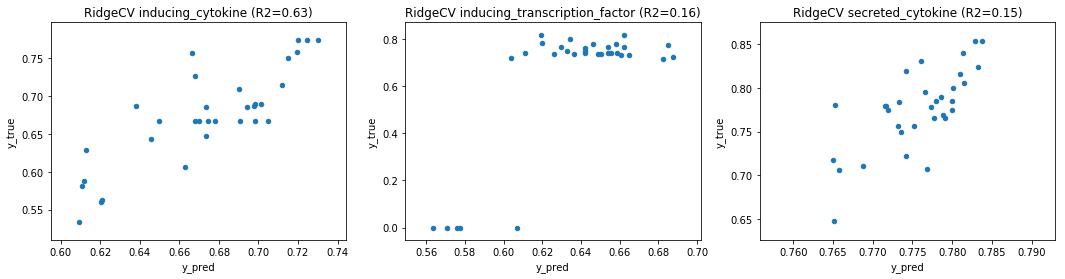

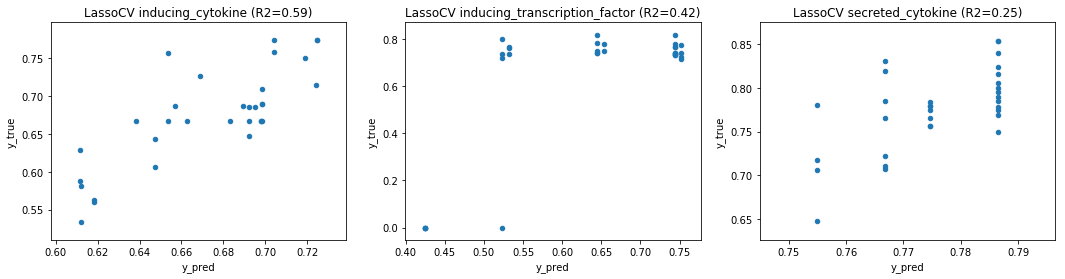

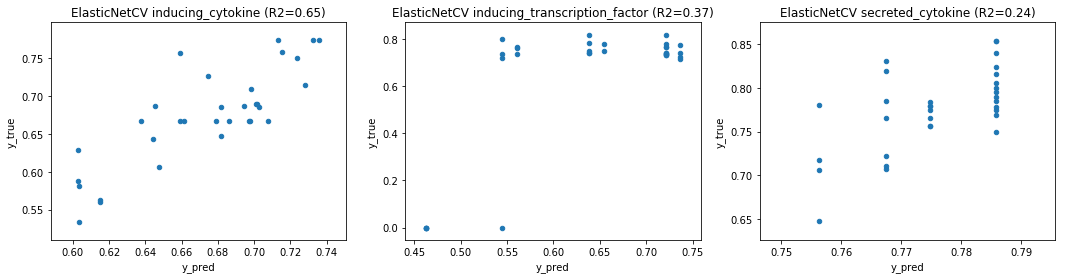

In [25]:
df_coef = pd.concat([
    get_coefs(RidgeCV(normalize=True, cv=5))[1],
    get_coefs(LassoCV(normalize=True, cv=5, random_state=1))[1],
    get_coefs(ElasticNetCV(normalize=True, cv=5, random_state=1))[1]
])

# Add weight for each model as R2 for model / R2 for all models
df_coef = df_coef.groupby('task', group_keys=False).apply(lambda g: g.assign(weight=(g['score'] / g['score'].sum())))
df_coef = df_coef.set_index(['task', 'score', 'est', 'weight'])

df_coef.head()

In [26]:
df_coef_lng = df_coef.rename_axis('parameter', axis='columns').stack().rename('value').reset_index()
df_coef_lng['weighted_value'] = df_coef_lng['value'] * df_coef_lng['weight']
df_coef_lng.head()

,task,score,est,weight,parameter,value,weighted_value
0,inducing_cytokine,0.62804,RidgeCV,0.337009,bidirectional:False,0.000000,0.000000
1,inducing_cytokine,0.62804,RidgeCV,0.337009,cell_type:LSTM,0.000000,0.000000
2,inducing_cytokine,0.62804,RidgeCV,0.337009,dropout:0.0,-0.001687,-0.000569
3,inducing_cytokine,0.62804,RidgeCV,0.337009,dropout:0.25,-0.002135,-0.000719
4,inducing_cytokine,0.62804,RidgeCV,0.337009,dropout:0.5,-0.002507,-0.000845


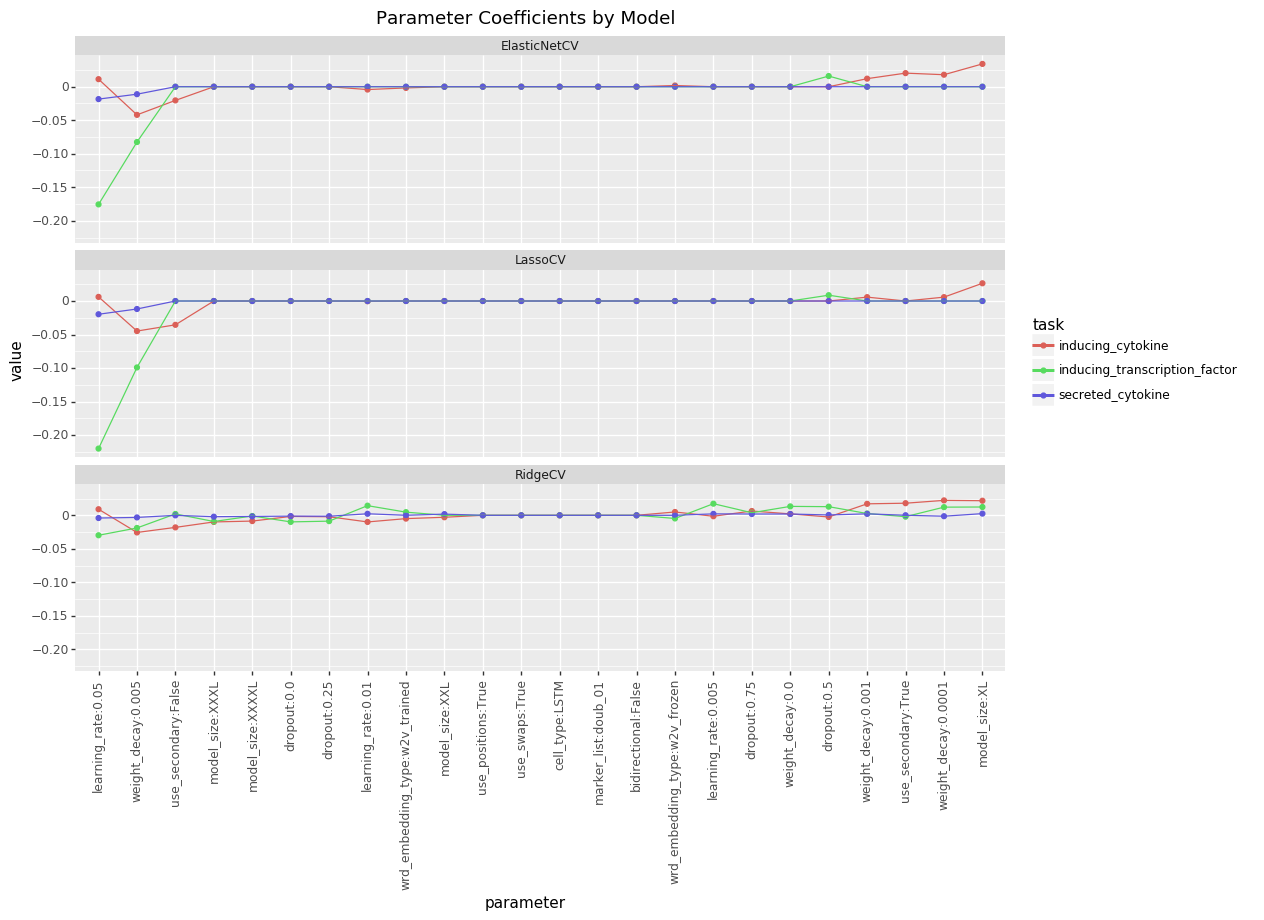

<ggplot: (-9223363242900474820)>

In [27]:
(
    pn.ggplot(
        df_coef_lng.assign(parameter=lambda df: pd.Categorical(
            df['parameter'], ordered=True, 
            categories=df.groupby('parameter')['weighted_value'].mean().sort_values().index
        )), 
        pn.aes(x='parameter', y='value', fill='task', color='task', group='task')
    ) + 
    pn.geom_point() +
    pn.geom_line() + 
    pn.ggtitle('Parameter Coefficients by Model') + 
    pn.facet_wrap('~ est', ncol=1) +
    pn.theme(figure_size=(12, 8), axis_text_x=pn.element_text(rotation=90, hjust=.5))
)

### Score Distributions

In [28]:
df_score = pd.concat([v[1].assign(task=k) for k, v in results.items()])
df_score.head()

,iteration,type,metric,value,task
0,0,,epoch,45.000000,inducing_cytokine
1,0,test,accuracy,0.660000,inducing_cytokine
2,0,test,ct,50.000000,inducing_cytokine
3,0,test,f1,0.666667,inducing_cytokine
4,0,test,loss,1.041148,inducing_cytokine


In [29]:
# Label balance
df_lbl = df_cand.assign(label=lambda df: np.where(df['label'] > .5, 1, 0))
pd.concat([
    df_lbl.assign(agg='count').groupby(['task', 'split', 'agg'])['label'].value_counts().unstack([-2, -1]),
    df_lbl.assign(agg='percent').groupby(['task', 'split', 'agg'])['label'].value_counts(normalize=True).unstack([-2, -1]).round(2)
], axis=1)

agg                                 count       percent      
label                                   0     1       0     1
task                          split                          
inducing_cytokine             test    246    25    0.91  0.09
                              train  9075   925    0.91  0.09
                              val     189    14    0.93  0.07
inducing_transcription_factor test    224    57    0.80  0.20
                              train  6004  3996    0.60  0.40
                              val     174    35    0.83  0.17
secreted_cytokine             test    224    50    0.82  0.18
                              train  6478  3522    0.65  0.35
                              val     169    36    0.82  0.18

In [30]:
df_top_score = (
    df_score
    # Pivot to task and hyperparameter config number (all scores already filtered to best epoch)
    .pivot_table(index=['task', 'iteration'], columns=['metric', 'type'], values='value')
    # Remove models with early top score
    .pipe(lambda df: df[df[('epoch', '')] >= 5])
    # Filter to best model config based on validation score
    .pipe(lambda df: df.groupby('task').apply(lambda g: g.iloc[np.argmax(g[('f1', 'validation')].values)]))
)
df_top_score.head()

metric                         accuracy                          ct           \
type                               test  training validation   test training   
task                                                                           
inducing_cytokine              0.540000  0.634054   0.750000   50.0   1850.0   
inducing_transcription_factor  0.666667  0.963000   0.814286  114.0   5000.0   
secreted_cytokine              0.760000  0.854200   0.847222  100.0   5000.0   

metric                                    epoch        f1            \
type                          validation             test  training   
task                                                                  
inducing_cytokine                   28.0   22.0  0.610169  0.670239   
inducing_transcription_factor       70.0   21.0  0.707692  0.964916   
secreted_cytokine                   72.0  105.0  0.789474  0.855729   

metric                                    ... precision@70 precision@80  \
type                          validation  ...   validation         test   
task                                      ...                             
inducing_cytokine               0.774194  ...     0.000000     0.000000   
inducing_transcription_factor   0.816901  ...     0.774194     0.677419   
secreted_cytokine               0.853333  ...     0.828571     0.787234   

metric                                             precision@90            \
type                           training validation         test  training   
task                                                                        
inducing_cytokine              0.000000   0.000000     0.000000  0.000000   
inducing_transcription_factor  0.977435   0.758621     0.708333  0.986198   
secreted_cytokine              0.925014   0.862069     0.818182  0.949452   

metric                                      recall                       
type                          validation      test  training validation  
task                                                                     
inducing_cytokine               0.000000  0.720000  0.743784   0.857143  
inducing_transcription_factor   0.772727  0.807018  0.996475   0.828571  
secreted_cytokine               0.904762  0.900000  0.863763   0.888889  

[3 rows x 34 columns]

In [31]:
# Scores at best validation F1 iteration
def get_scores_table(metrics):
    df_bal = (
        df_lbl.assign(metric='balance').groupby(['task', 'metric', 'split'])['label'].value_counts(normalize=True)
        .unstack().round(2)[1].unstack([-2, -1])
    )
    return (
        df_top_score[metrics]
        .round(2)
        .pipe(lambda df: pd.concat([df, df_bal], axis=1, sort=True))
        .style.background_gradient(cmap='Greens', low=.1, high=.3)
    )

In [32]:
# Scores at best validation F1 iteration
get_scores_table(['ct', 'f1', 'accuracy', 'precision', 'recall'])

In [33]:
# Median scores
p = (
    df_score
    .pipe(lambda df: df[df['metric'].isin(['precision', 'recall', 'f1'])])
    .groupby(['task', 'metric', 'type'])['value'].describe()[['mean', '25%', '50%', '75%']].unstack()['50%'].unstack()[['test', 'validation']]
    .round(3)
    .style.background_gradient(cmap='Greens', low=.3, high=.9)
)

In [34]:
p

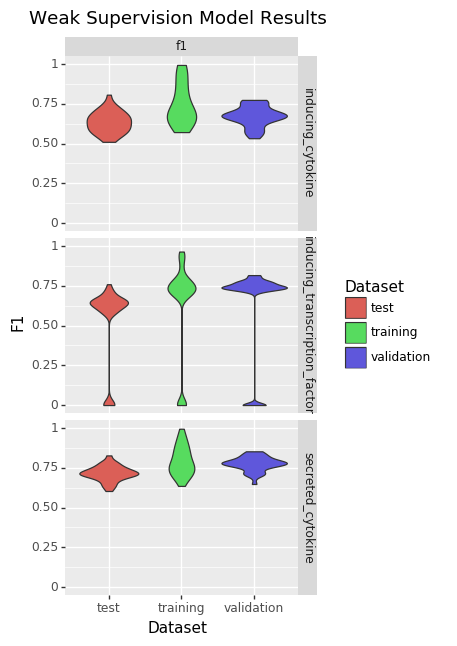

<ggplot: (-9223363242900791664)>

In [35]:
(
    pn.ggplot(
        df_score.pipe(lambda df: df[df['metric'].isin(['f1'])]),
        pn.aes(x='type', y='value', fill='type')
    ) + 
    pn.geom_violin() + 
    pn.ylim(0, 1) +
    pn.labs(y='F1', title='Weak Supervision Model Results', x='Dataset', fill='Dataset') + 
    pn.facet_grid('task ~ metric', scales='free') + 
    pn.theme(figure_size=(3, 7))
)

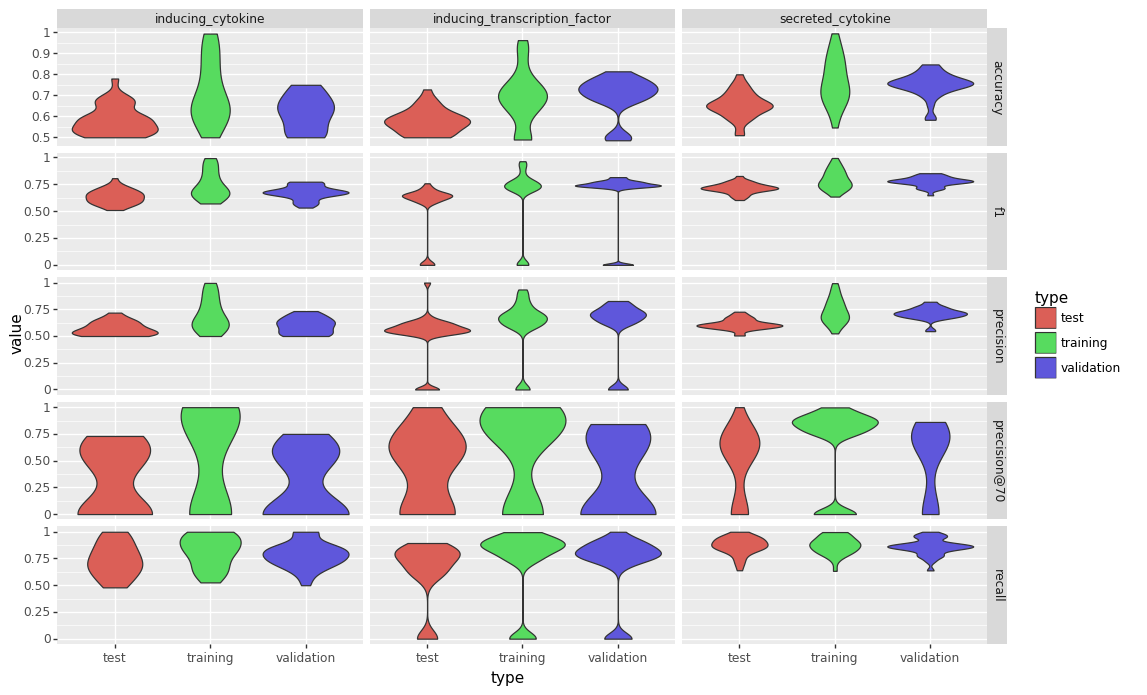

<ggplot: (8793933167950)>

In [36]:
(
    pn.ggplot(
        df_score.pipe(lambda df: df[df['metric'].isin(['f1', 'accuracy', 'precision', 'precision@70', 'recall'])]),
        pn.aes(x='type', y='value', fill='type')
    ) + 
    pn.geom_violin() + 
    pn.facet_grid('metric ~ task', scales='free') + 
    pn.theme(figure_size=(12, 8))
)

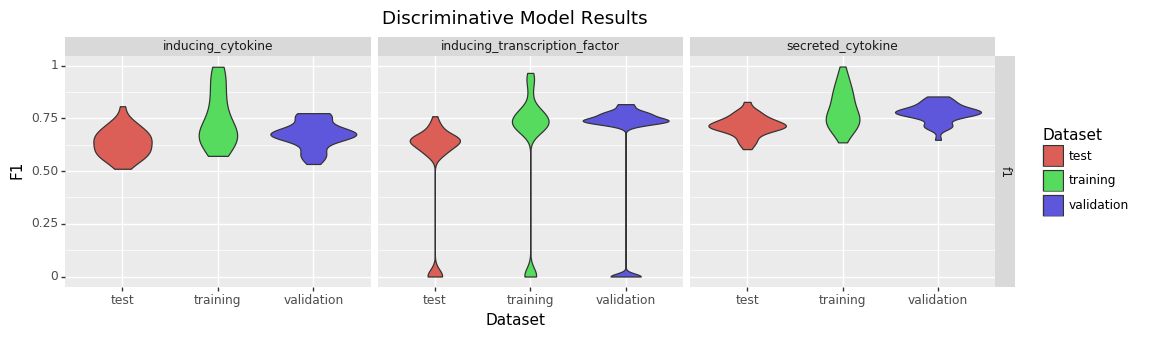

<ggplot: (8793970808135)>

In [37]:
(
    pn.ggplot(
        df_score.pipe(lambda df: df[df['metric'].isin(['f1'])]),
        pn.aes(x='type', y='value', fill='type')
    ) + 
    pn.geom_violin() + 
    pn.labs(y='F1', title='Discriminative Model Results', x='Dataset', fill='Dataset') + 
    pn.facet_grid('metric ~ task', scales='free') + 
    pn.theme(figure_size=(12, 3))
)

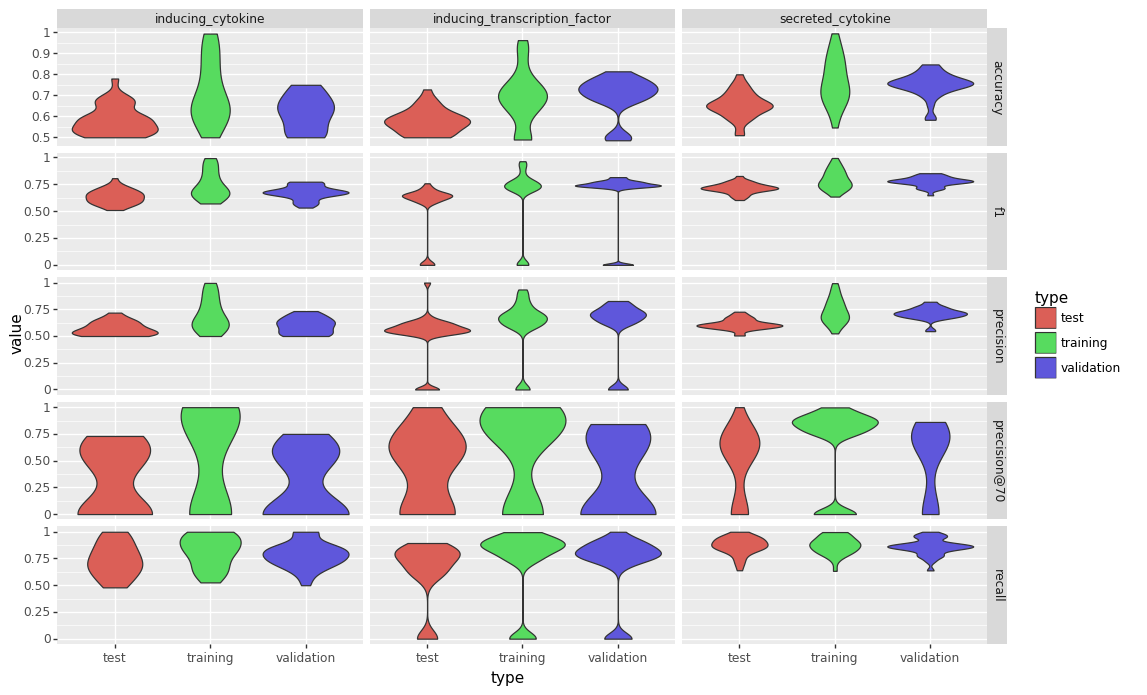

<ggplot: (-9223363242900820171)>

In [38]:
(
    pn.ggplot(
        df_score.pipe(lambda df: df[df['metric'].isin(['f1', 'accuracy', 'precision', 'precision@70', 'recall'])]),
        pn.aes(x='type', y='value', fill='type')
    ) + 
    pn.geom_violin() + 
    pn.facet_grid('metric ~ task', scales='free') + 
    pn.theme(figure_size=(12, 8))
)

In [39]:
# Dump all summaries
pd.set_option('display.max_rows', 100)
(
    df_score
    .pipe(lambda df: df[~df['metric'].isin(['lr', 'loss', 'ct', 'epoch'])])
    .groupby(['task', 'type', 'metric'])['value'].describe()
    .style.background_gradient(subset=pd.IndexSlice[:,'mean'])
)

## Export

Export scores:

In [40]:
df_exp = df_top_score.stack().stack().rename('value').reset_index().rename(columns={'type': 'split'}).assign(model='rnn-all')
assert df_exp.groupby(['task', 'metric', 'split']).size().max() == 1
df_exp.head()

,task,split,metric,value,model
0,inducing_cytokine,,epoch,22.000000,rnn-all
1,inducing_cytokine,test,accuracy,0.540000,rnn-all
2,inducing_cytokine,test,ct,50.000000,rnn-all
3,inducing_cytokine,test,f1,0.610169,rnn-all
4,inducing_cytokine,test,loss,0.673339,rnn-all


In [41]:
df_exp[df_exp['metric'] == 'epoch']['value'].value_counts()

105.0    1
21.0     1
22.0     1
Name: value, dtype: int64

In [42]:
path = osp.join(output_dir, 'scores.csv')
df_exp.to_csv(path, index=False)
path

'/lab/data/results/modeling-rnn-all/run4/scores.csv'